In this homework, you need to solve two tasks. For problems with theoretical calculations, you need to show a sufficient number of intermediate steps to explain how you have obtained the result. 
* Formulas are expected in Latex style inside the notebook. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). 
* Overall, there are 45 points, however, you can get a maximum of 40 points for this assignment( `your_points = max(your_points, 40)`). 
* No bonus points will be transferred to the next assignment.

# Task 1. Moscow weather (20 points)

In this task you need to estimate parameters and their confidence intervals for a given sample. As data, you will explore Moscow weather. You can look at some visualizations of martian weather [here](https://pudding.cool/2018/01/mars-weather/) (completely unrelated to Moscow weather, though).

First of all, you will need some libraries. Also, fix random seed to get reproducable results.

In [120]:
import numpy as np
from numpy.random import choice, seed
import pandas as pd
from scipy.stats import sem, norm, skew, chi2
import matplotlib.pyplot as plt
from tqdm import tqdm


seed(366)

In [121]:
import matplotlib as mp
import matplotlib.font_manager

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

mp.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
mp.rcParams['legend.handletextpad'] = 0.5
mp.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
mp.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
mp.rcParams['font.size'] = 12
mp.rcParams['font.family'] = 'serif'
mp.rcParams['font.serif'] = 'Times New Roman'
mp.rcParams['axes.labelsize'] = labelsize
mp.rcParams['axes.titlesize'] = titlesize
mp.rcParams['axes.unicode_minus'] = False

mp.rc('xtick', labelsize=xticksize)
mp.rc('ytick', labelsize=yticksize)
mp.rc('legend', fontsize=legendsize)

mp.rc('font', **{'family':'serif'})

## Part 1. Load data (1 point)

You need to load data from `moscow-weather.csv`, take feature for your variant, remove absent values (`Nan`s) and convert sample to `int` type. 

### a) 

`feature_name = "TMIN"`

### b)

`feature_name = "TMAX"`

In [122]:
feature_name = "TMIN"
df = pd.read_csv("moscow-weather.csv")[feature_name]
sample_full = df.dropna().values.astype(int)

Let's take a four month period or ~ 121 days. Sample them randomly from full sample using function `choice`(from `numpy.random`) with parameter `replace=False`.

In [123]:
N = 121

sample_part = choice(a=df, size=N, replace=False)

Plot values frequences for full and partial sample using bar plot.

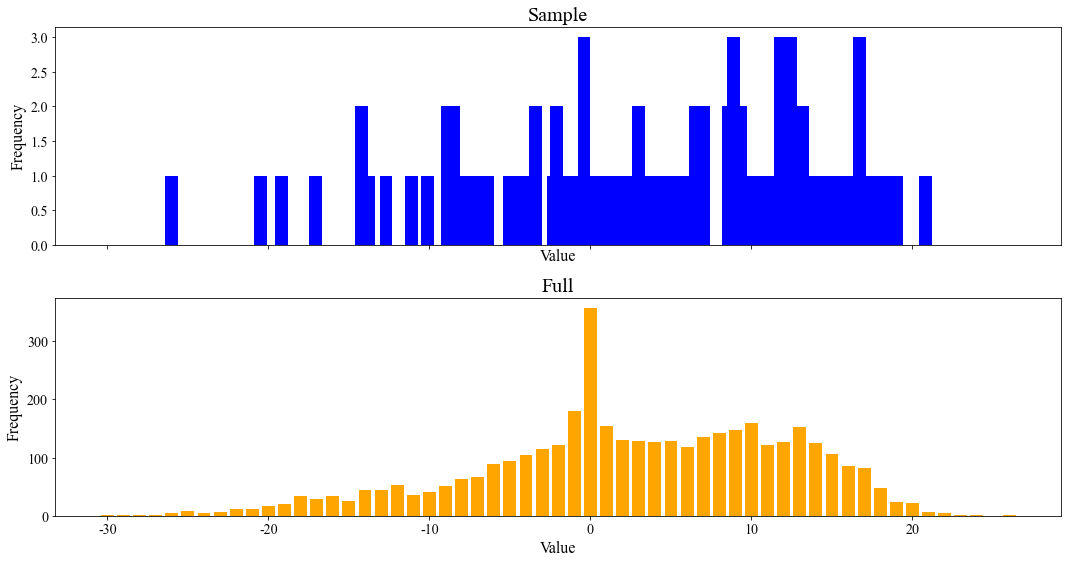

In [124]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)

vals, counts = np.unique(sample_part, return_counts=True)
ax[0].bar(x=vals, height=counts, color='blue')
ax[0].set_title('Sample')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')

vals, counts = np.unique(sample_full, return_counts=True)
ax[1].bar(x=vals, height=counts, color='orange')
ax[1].set_title('Full')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

## Part 2. Parameter estimation (6 points)
Find the following parameters' estimates and their 95% confidence intervals (except for `mode` and `skewness`). You need to show theoretical calculations (with intermediate steps) for estimates and intervals (with intermediate steps) and then make simulation.

### a) Mean and CI

According to the $\underline{\text{Central Limit Theorem}}$:

If $X^n = (X_1, X_2, ..., X_n)$ are $n$ random samples drawn from same unknown distribution with both unknown finite $\mathbb{E}$ and $\mu$.

Then, $$\bar{X_n} = \frac{\sum_{i = 1}^n X_i}{n} \rightsquigarrow \mathbb{N}(\mu, \frac{\sigma^{2}}{n})$$

Moreover, applying $Z$-tranformation:

$$Z_n = \frac{\bar{X_n} - \mu}{\sigma / n} \rightsquigarrow \mathbb{N}(0, 1)$$

In order to estimate true mean $\mu$ we somehow should estimate unknown $\sigma$

We could use unbiased sample variance:

$$\sigma_n^2 = \frac{1}{(n - 1)} \cdot \sum_{i = 1}^n(x_i - \bar{X})^2$$ instead of true $\mu$ (due to Slutsky's theorem is saves same convergence)

$$\Rightarrow \hat{mean} = \bar{X}$$

Moreover, derived properties, allow us to estimate confidence interval with confidence level $$1 - \alpha|_{\alpha=0.05} = 0.95$$, which is the same as 95%:

$$\Rightarrow CI(\hat{mean}) = (\hat{mean}−z_{\frac{\alpha}{2}}\frac{\sigma_n}{\sqrt{n}}; \hat{mean}+z_{\frac{\alpha}{2}}\frac{\sigma_n}{\sqrt{n}})$$

In [125]:
def get_mean_ci(sample, alpha):
    
    mean = np.mean(sample)
    z = norm.ppf(1 - alpha / 2)
    error = sem(sample)
    
    return mean, (mean - z * error, mean + z * error)

In [126]:
mean, (lower, upper) = get_mean_ci(sample_part, alpha=0.05)
f"Mean {mean:.3f} with confidence interval ({lower:.3f}, {upper:.3f})"

'Mean 3.297 with confidence interval (1.592, 5.001)'

### b) Median and CI

Here you can assume that PDF is continuous at the median point and provide a normal-based interval.

$$ \hat{median} = \begin{cases}
      X_{\frac{(n + 1)}{2}} & \text{$n$ i odd}\\
      \frac{\left(X_{(\frac{n}{2} + 1)} + X_{\frac{n}{2}}\right)}{2} & \text{$n$ is even}\\
    \end{cases}$$

$$ CI(\hat{median}) = \hat{median} \pm SE_{med} * t_{p,\alpha/2}$$

Where 

$SE_{med} = \frac{1}{2} \cdot (X_{(U_n)} − X_{(L_n+1)})$

$U_n = n - L_n$

$L_n = \lceil n/2 \rceil − \lceil \sqrt{n/4} \rceil$

$t_{p,\alpha/2}$ 

is the Student distribution 95%-quantile with 

$p  = U_n - L_n - 1 \approx \lceil \sqrt{n} \rceil$

number of degrees of freedom

$\href{http://lagrange.math.siu.edu/Olive/ppmedci.pdf}{source\ paper}$

In [127]:
from scipy.stats import t as student

In [128]:
def get_median_ci(sample, alpha):
    
    n = sample.shape[0]
    
    median = np.median(sample)
    deg_free = np.ceil(np.sqrt(n))
    t = student(df=deg_free).ppf((1 - alpha / 2))
    
    l = np.ceil(n / 2) - np.ceil(np.sqrt(n) / 4)
    u = n - l
    
    error = 0.5 * (sample[u.astype(int)] - sample[(l + 1).astype(int)])
    
    return median, (median - t * error, median + t * error)

In [129]:
median, (lower, upper) = get_median_ci(sample_part, alpha=0.05)
f"Median {median:.3f} with normal-based confidence interval ({lower:.3f}, {upper:.3f})"

'Median 4.000 with normal-based confidence interval (1.249, 6.751)'

### c) Variance and CI

Here you can assume that the sample comes from a normal distribution, but the mean and variance are not known.

Then, $X^n = (X_1, X_2, ..., X_n) \sim \mathbb{N}(\mu, \sigma^2)$

Using Fisher's theorem:

Random variable $\frac{(n - 1)S^2}{\sigma^2} \sim \chi^2_{n - 1}$,

Where $S^2$ is unbiased variance, which we used before:

$$S^2 = \frac{1}{(n - 1)} \cdot \sum_{i = 1}^n(x_i - \bar{X})^2$$

Thus, we got:

$$\mathbb{P}\left(\chi^2_{\alpha/2, n - 1} \leq H \leq \chi^2_{1 - \alpha/2, n - 1}\right) = 1 - \alpha$$

$$ \hat{Variance} = \frac{1}{(n - 1)}  \sum_{i = 1}^n(x_i - \hat{mean})^2$$

$\Rightarrow CI(\hat{Variance}) = {\displaystyle \mathbb {P} \left({\frac {(n-1)S^{2}}{\chi _{1-{\frac {\alpha }{2}},n-1}^{2}}}\leq \hat{Variance}\leq {\frac {(n-1)S^{2}}{\chi _{{\frac {\alpha }{2}},n-1}^{2}}}\right)=1-\alpha }$

$\href{https://ru.wikipedia.org/w/index.php?title=Доверительный_интервал_для_дисперсии_нормальной_выборки&oldid=107742004}{source\ paper}$

In [136]:
def get_variance_ci(sample, alpha):
    
    n = sample.shape[0]
    
    var = np.std(sample)**2
    l_b, r_b = var / chi2.ppf([1 - alpha / 2, alpha / 2], df=n-1)
    return var, ((n - 1) * l_b, (n - 1) * r_b)

In [137]:
var, (lower, upper) = get_variance_ci(sample_part, alpha=0.05)
f"Variance {var:.3f} with confidence interval ({lower:.3f}, {upper:.3f})"

'Variance 90.739 with confidence interval (71.536, 118.907)'

### d) Mode (most frequent value in a sample)

In [138]:
def get_mode(sample):
    vals, counts = np.unique(sample_part, return_counts=True)
    return vals[np.argsort(counts)[-1]]

In [139]:
mode = get_mode(sample_part)
f"Mode: {mode}"

'Mode: -0.4'

### e) Skewness

In [140]:
def get_skew(sample):
    return skew(sample)

In [141]:
skewness = get_skew(sample_part)
f"Skewness: {skewness:e}"

'Skewness: -4.888542e-01'

## Part 3. Bootstrap (4 points)

Find confidence intervals for following estimates using bootsrap. Use function `choice` with parameter `replace=True` for bootstrap sampling. Try different numbers of generated samples.

In [142]:
def get_bootstrap_variance(sample, statistic, n_runs=100):
    
    boot_sample = []
    n = sample.shape[0]
    
    for _ in range(n_runs):
        boot_sample.append(statistic(choice(a=sample, size=n, replace=True)))
    
    mean = np.mean(boot_sample)
    
    return np.mean((boot_sample - mean)**2)

### a) Mean and CI

In [143]:
def get_bootstrap_mean_ci(sample, alpha, n_runs=100):    
    mean = np.mean(sample)
    z = norm.ppf(1 - alpha / 2)
    error = np.sqrt(get_bootstrap_variance(sample, np.mean, n_runs))
    
    return mean, (mean - z * error, mean + z * error)

In [144]:
mean, (lower, upper) = get_bootstrap_mean_ci(sample_part, alpha=0.05)
f"Mean {mean:.3f} with confident interval ({lower:.3f}, {upper:.3f})"

'Mean 3.297 with confident interval (1.675, 4.918)'

### b) Median and CI

In [145]:
def get_bootstrap_median_ci(sample, alpha, n_runs=100):    
    mean = np.median(sample)
    z = norm.ppf(1 - alpha / 2)
    error = np.sqrt(get_bootstrap_variance(sample, np.median, n_runs))
    
    return mean, (mean - z * error, mean + z * error)

In [146]:
median, (lower, upper) = get_bootstrap_median_ci(sample_part, alpha=0.05)
f"Median {median:.3f} with normal-based confident interval ({lower:.3f}, {upper:.3f})"

'Median 4.000 with normal-based confident interval (1.785, 6.215)'

### c) Variance and CI

In [147]:
def get_bootstrap_variance_ci(sample, alpha, n_runs=100):    
    mean = np.var(sample)
    z = norm.ppf(1 - alpha / 2)
    error = np.sqrt(get_bootstrap_variance(sample, np.var, n_runs))
    
    return mean, (mean - z * error, mean + z * error)

In [148]:
var, (lower, upper) = get_bootstrap_variance_ci(sample_part, alpha=0.05)
f"Variance {var:.3f} with confident interval ({lower:.3f}, {upper:.3f})"

'Variance 90.739 with confident interval (71.754, 109.723)'

## Part 4. Comparison with true values (1 point)

Compare with estimates calculated over full sample. Write conclusion about estimates and their confidence intervals obtained without and with bootstrap. Also, you can share some conclusions about moscow weather :)

In [149]:
ints_funcs = [
    get_mean_ci,
    get_median_ci,
    get_variance_ci
]

boot_ints_funcs = [
    get_bootstrap_mean_ci,
    get_bootstrap_median_ci,
    get_bootstrap_variance_ci
]

In [150]:
print('True vs Sample vs Bootstrapped:\n')

funcs = [np.mean, np.median, np.var]

for f, s, b in zip(funcs, ints_funcs, boot_ints_funcs):
    
    print(f.__name__.upper())
    
    print(f'True: {f(sample_full):.3f}')
    
    a, (a1, a2) = s(sample_part, 0.05)
    print(f'Sample: {a:.3f} in ({a1:.3f}, {a2:.3f})')
    
    a, (a1, a2) = b(sample_part, 0.05)
    print(f'Boot: {a:.3f} in ({a1:.3f}, {a2:.3f})\n')
    
vals, counts = np.unique(sample_full, return_counts=True)
true_mode = vals[np.argsort(counts)[-1]]

vals, counts = np.unique(sample_part, return_counts=True)
mode = vals[np.argsort(counts)[-1]]

print(f'SKEW\n {skew(sample_full):.3f} vs {get_skew(sample_part):.3f}')

print(f'\nMODE\n {true_mode:.3f} vs {mode:.3f}')

True vs Sample vs Bootstrapped:

MEAN
True: 2.616
Sample: 3.297 in (1.592, 5.001)
Boot: 3.297 in (1.481, 5.113)

MEDIAN
True: 3.000
Sample: 4.000 in (1.249, 6.751)
Boot: 4.000 in (1.758, 6.242)

VAR
True: 89.005
Sample: 90.739 in (71.536, 118.907)
Boot: 90.739 in (67.933, 113.545)

SKEW
 -0.475 vs -0.489

MODE
 0.000 vs -0.400


## Conclusion:

### It look's like that boostrap has more narrow and precise intervals

## Part 5. Confidence intervals and sample size (8 points)

Compare the size of confidence intervals **for the mean** obtained without and with bootstrap. Additionally, compare the empirical coverage of different confidence intervals (by generating sufficient number of samples of corresponding size and calculating proportion of cases when the interval covers the mean of the full sample). Consider sizes `[42, 84, 168, 335, 670, 1340]`. Plot results and make conclusion about their accuracy.

In [151]:
seed(476)
sizes = np.r_[42, 84, 168, 335, 670, 1340]

In [152]:
norm_int, boot_int = [], []

for i, N_i in enumerate(sizes): 
    sample = choice(sample_full, size=N_i, replace=False)
    
    val, (l, b) = get_mean_ci(sample[:N_i], alpha=0.05)
    norm_int.append(b - l)
    
    sample = choice(sample_full, size=N_i, replace=True)
    val, (l, b) = get_bootstrap_mean_ci(sample, alpha=0.05)
    boot_int.append(b - l)

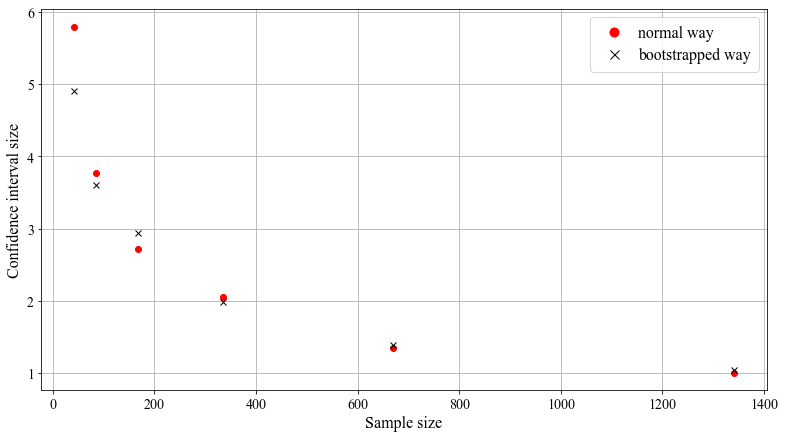

In [153]:
plt.figure(figsize=(13, 7))

plt.plot(sizes, norm_int, "ro", label="normal way")
plt.plot(sizes, boot_int, "kx", label="bootstrapped way")

plt.ylabel("Confidence interval size")
plt.xlabel("Sample size")

plt.grid(True)
plt.legend()
plt.show()

In [154]:
def get_int_vals(stat_id, sample_size):
    norm_int = np.empty((len(sizes), 2))
    boot_int = np.empty((len(sizes), 2))

    sample = choice(sample_full, sample_size, False)
    _, norm_int = ints_funcs[stat_id](sample, alpha=0.05)

    sample = choice(sample_full, sample_size, True)
    _, boot_int = boot_ints_funcs[stat_id](sample, alpha=0.05, n_runs=sample_size)
    
    return (norm_int, boot_int)

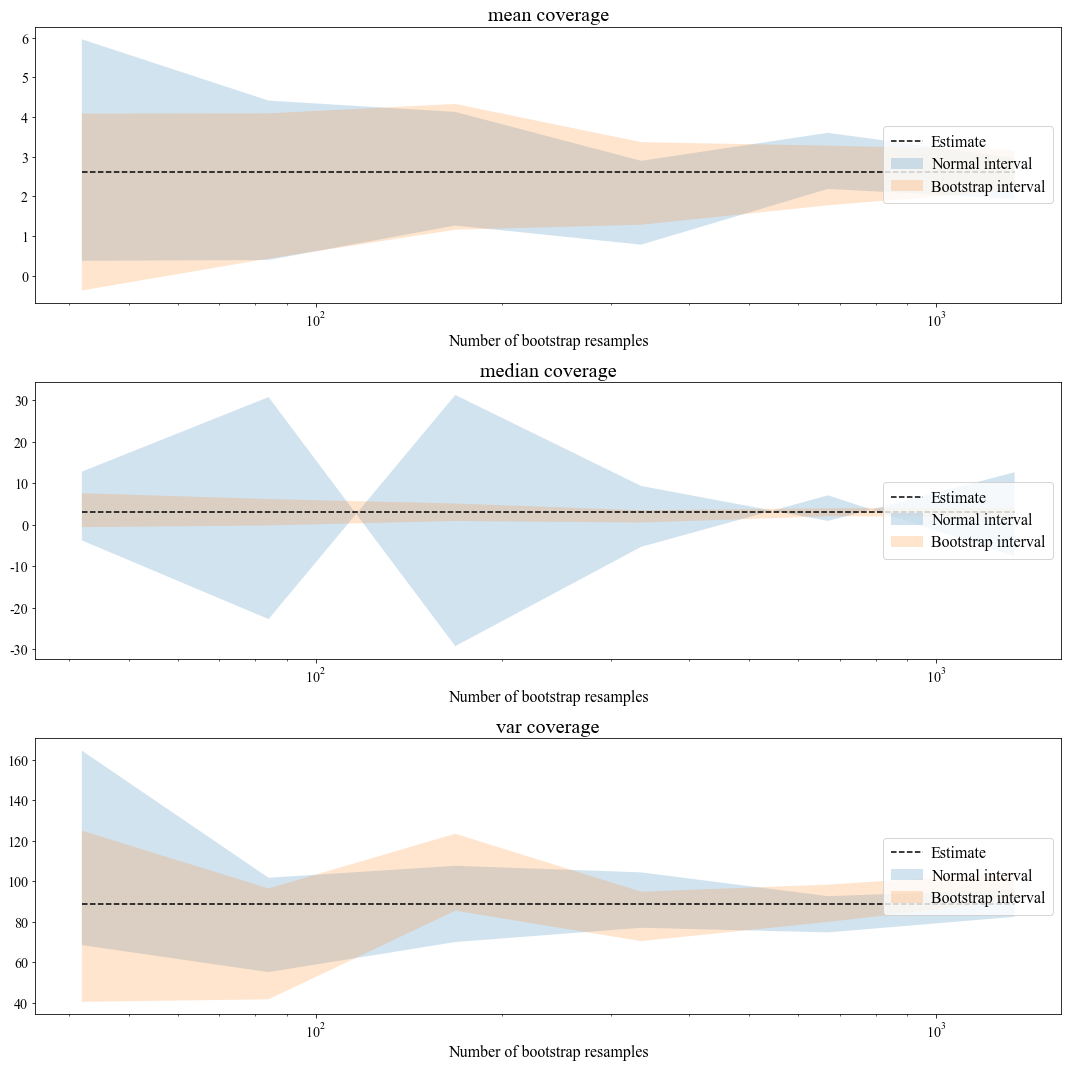

In [101]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

for stat_id, gen_statistic in enumerate([np.mean, np.median, np.var]):
    norm_ints = np.empty((len(sizes), 2))
    boot_ints = np.empty((len(sizes), 2))

    for index, size in enumerate(sizes):
        norm_ints[index], boot_ints[index] = get_int_vals(stat_id=stat_id, sample_size=size)

    ax[stat_id].fill_between(sizes, norm_ints[:, 0], norm_ints[:, 1], alpha=0.2, label='Normal interval')
    ax[stat_id].fill_between(sizes, boot_ints[:, 0], boot_ints[:, 1], alpha=0.2, label='Bootstrap interval')
    ax[stat_id].plot(sizes, [gen_statistic(sample_full)]*len(sizes), 'k--', label='Estimate')
    ax[stat_id].set_xscale('log')
    ax[stat_id].set_xlabel('Number of bootstrap resamples')
    ax[stat_id].set_title(gen_statistic.__name__ + ' coverage')
    ax[stat_id].legend(loc='right')

plt.tight_layout()
plt.show()

In [77]:
def get_cov_prob(y_lower, y_upper, y_true, rtol=1.e-4, atol=1.e-6):
    
    n_cov = ((y_true >= y_lower) & (y_true <= y_upper))
    p_cov = np.mean(n_cov)
    return n_cov.sum().astype(int), p_cov

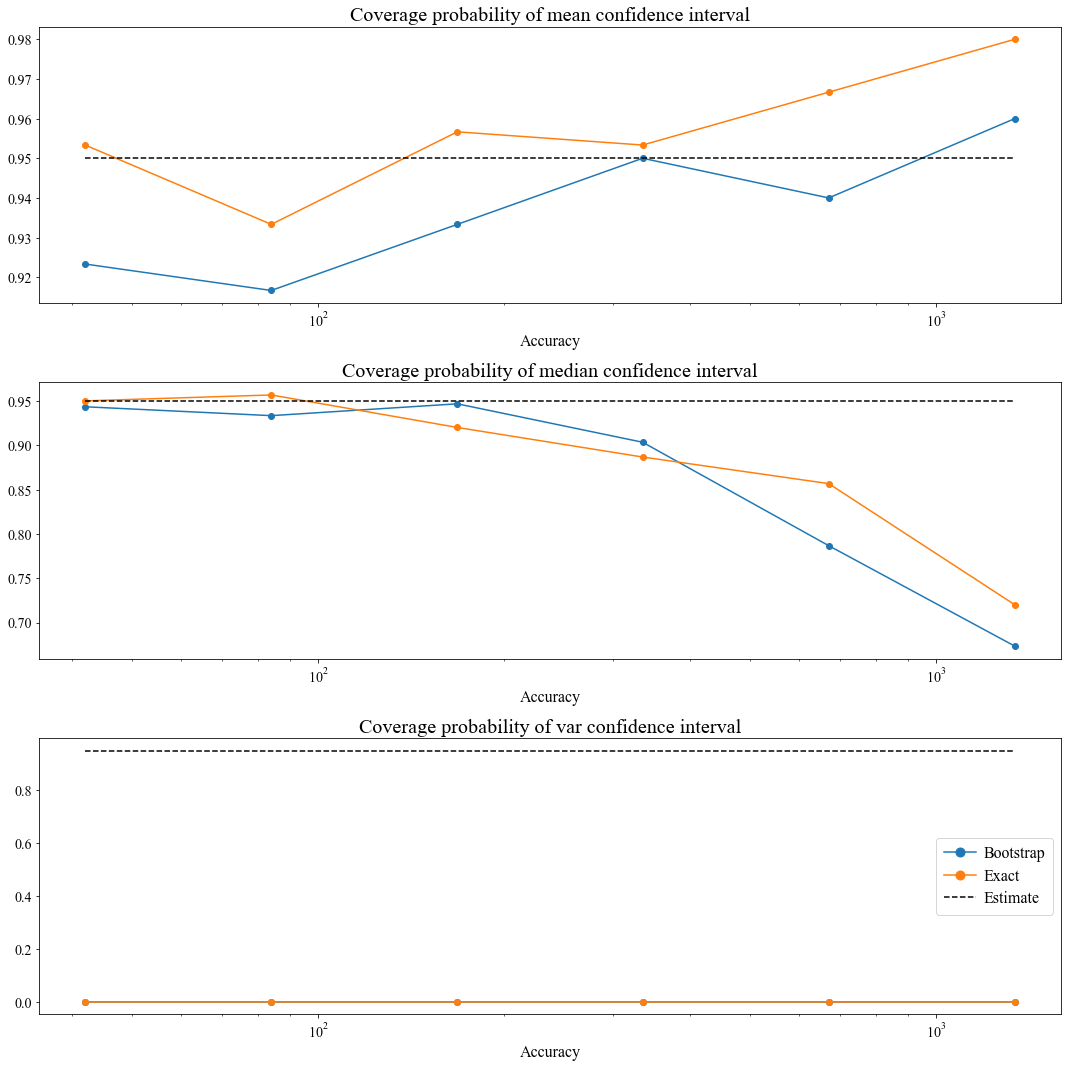

In [155]:
num_repeats = 300

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

for stat_id, gen_statistic in enumerate([np.mean, np.median, np.var]):

    n_cov_exact = np.empty(len(sizes))
    p_cov_exact = np.empty_like(n_cov_exact)
    n_cov_boot = np.empty_like(n_cov_exact)
    p_cov_boot = np.empty_like(n_cov_exact)

    for i, s in enumerate(sizes):
        boot_ints = np.empty((num_repeats, 2))
        exact_ints = np.empty((num_repeats, 2))
        for j in range(num_repeats):
            exact_ints[j], boot_ints[j] = get_int_vals(stat_id=0, sample_size=s)

        true_val =  gen_statistic(sample_full)
        n_cov_boot[i], p_cov_boot[i] = get_cov_prob(boot_ints[:, 0], boot_ints[:, 1], true_val)
        n_cov_exact[i], p_cov_exact[i] = get_cov_prob(exact_ints[:, 0], exact_ints[:, 1], true_val)
        
    ax[stat_id].plot(sizes, p_cov_boot, '-o', label='Bootstrap')
    ax[stat_id].plot(sizes, p_cov_exact, '-o', label='Exact')
    ax[stat_id].plot(sizes, [0.95]*len(sizes), 'k--', label='Estimate') 

    ax[stat_id].set_xscale('log')
    ax[stat_id].set_title(f'Coverage probability of {gen_statistic.__name__} confidence interval')
    ax[stat_id].set_xlabel('Sample size')
    ax[stat_id].set_xlabel('Accuracy')

plt.tight_layout()
plt.legend()
plt.show()    

## Conclusion:

### Percentage of guessed intervals is increasing, which allows us to conclude, that we did a great job!

# Task 2. Currency in RC-circuit (25 points)

In this part you need to estimate parameters and apply delta method. 

First of all, you will need some libraries. Also, fix random seed to get reproducible results.

In [73]:
import numpy as np
from scipy.stats import norm, uniform
from numpy.random import choice, seed

seed(100)

## Part 1. Estimate parameters (4 points)

Assume that there is an RC-circuit with a capacitor and a resistor. 
<img src="circuit.png" width="200"  class="center">

We charge the capacitor until it reaches voltage $V$ and measure current intensity. In this case voltage on the capacitor yields the formula for exponential decay:

$$ V_C(t) = V e^{-\frac{t}{RC}} $$

Let's assume that voltage $V$ and resistence $R$ are independent and belong to the following distributions:

$V \sim \mathcal{N}(4, 1)$, 

$R \sim \mathcal{U}(6, 11)$

Consider **true values** for $V$ and $R$ to be the means of the corresponding distributions.

Generate sample for $V$ of size 100. Apply maximum likelihood to estimate the mean. Show theoretical calculations for the estimates (with intermediate steps) and make simulation.


MLE:

$$f_{\theta}(X) = \prod_{i=1}^n p_{\theta}(X_i)$$

Due to logarithm's monotony property we can apply following transition:
$$
    \log f_{\theta}(X) = \log \prod_{i=1}^n p_{\theta}(X_i)= -\frac{n}{2}\log(2\pi) - - \frac{n}{2}\log(\sigma^2) - {1 \over 2\sigma^2} \sum_{i = 1}^n (X_i - \theta)^2
$$

It is still the same optimisation problem.

Thus, we could find it's parameters with derivation:

${\partial \over \partial \theta} \log f_{\theta}(X) = \frac{n}{\sigma^2} \left(\overline{X} - \theta\right) = 0$

$\Rightarrow \theta = \overline{X}$

$$\Rightarrow \hat{V}_{n} = \overline{X}$$

In [118]:
df = np.random.normal(4, 1, 100)
res = np.sum(df) / 100

print(f'Mean estimate from MLE: {res:.3f}')

Mean estimate from MLE: 3.869


Generate sample for $R$ on size 100. Apply maximum likelihood to estimate the mean. Show theoretical calculations for estimates (with intermediate steps) and make simulation.

$$
    f_{\theta}(X) = \prod_{i=1}^n p_{\theta}(X_i)\mathbb{I}(X_i \in [a, b]) = \prod_{i=1}^n \frac{1}{(b - a)}\mathbb{I}(X_i \in [a, b]) = \frac{1}{(b - a)^n}\mathbb{I}(X_i \in [a, b])
$$

Looks like it's 2 params optimisation task. Thus, for $a$ we fix $b$ and vice versa.
In first case maximum reaches with $X_{(1)}$, whether in the second case it's $X_{(n)}$. 

Thus, MLE gives us:

$$\hat{R}_{n} = \frac{X_{(1)} + X_{(n)}}{2}$$



In [119]:
df = np.random.uniform(6, 11, 100)
res = (np.min(df) + np.max(df)) / 2

print(f'Mean estimate from MLE: {res:.3f}')

Mean estimate from MLE: 8.494


## Part 2. Apply delta method (8 points)

Assume, that we measure current intensity after 1 second. Let's take $C = 1$. In this case we get the following simplified formula:

$$I = \frac{V}{R} e^{-\frac{1}{R}}.$$

Find estimate for current and it's confidence interval. Show theoretical calculations for estimates (with intermediate steps) and make simulation.

$$\hat{I}_n = ...$$

$$ CI(\hat{I}_n) = ...$$

In [37]:
# Your code here

se = ...
f"SE for delta method: {se:e}"

TypeError: unsupported format string passed to ellipsis.__format__

## Part 3. Non-parametric bootstrap estimation (2 points)

Estimate confidence interval for $I$ using non-parametric bootstrap.

In [ ]:
# Your code here

se = ...
f"SE for non-parametric bootstrap: {se:e}"

## Part 4. Parametric bootstrap estimation (3 points)

Estimate confidence interval for $I$ using parametric bootstrap.

In [ ]:
# Your code here

se = ...
f"SE for parametric bootstrap: {se:e}"

## Part 5. Compare results (8 points)

Compare the size of confidence intervals obtained using delta method, parametric and non-parametric bootstrap. Additionally, compare the empirical coverage of different confidence intervals (by generating sufficient number of samples of corresponding size and calculating proportion of cases when the interval covers the true value for the current $I$). Consider sizes `[1e1, ..., 1e4]`. Plot results and make conclusion about their accuracy.

In [ ]:
sizes = np.logspace(1, 4, 4).astype(np.int)

In [ ]:
# Compare size of confidence intervals obtained using delta method, parametric and non-parametric bootstrap
# Your code here



In [ ]:
# Plot results
# Your code here


In [ ]:
# Compare an empirical coverage of different confidence intervals
# Your code here



In [ ]:
# Plot results
# Your code here



Your conclusion:

